## Lorenz System with Missing Variables

In [ ]:
# --> Simulating the Lorenz system.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from Lorenz import Lorenz

# --> Sets the parameters to their classical values.
sigma, rho, beta = 10., 28., 8./3.

# --> Integration time.
t = np.linspace(0, 20, 2000)

# --> Produce the date to be used in the sparse identification.
x0 = np.array([-8., 7., 27.]) # Initial condition.
x, dx = Lorenz(x0, sigma, rho, beta, t)

# --> Slightly different initial condition to highlight the chaotic nature.
y0 = np.array([-8.01, 7., 27.]) # Initial condition.
y, dy = Lorenz(y0, sigma, rho, beta, t)

In [ ]:
# --> Plot time traces of the two trajectories as well as the corresponding stange attractor.
w = 10
fig = plt.figure(figsize=(1.5*w, w/2))
gs = GridSpec(3, 6)

ax0 = fig.add_subplot(gs[0, :3])
ax0.plot(t, x[:, 0])
ax0.plot(t, y[:, 0])
ax0.set_ylabel('x')
ax0.set_xticks([])
ax0.set_xlim(0, 20)

ax1 = fig.add_subplot(gs[1, :3])
ax1.plot(t, x[:, 1])
ax1.plot(t, y[:, 1])
ax1.set_ylabel('y')
ax1.set_xticks([])
ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs[2, :3])
ax2.plot(t, x[:, 2])
ax2.plot(t, y[:, 2])
ax2.set_ylabel('z')
ax2.set_xlabel('t')
ax2.set_xlim(0, 20)

ax3 = fig.add_subplot(gs[:, 3:], projection='3d')
ax3.plot(x[:, 0], x[:, 1], x[:, 2])
ax3.plot(y[:, 0], y[:, 1], y[:, 2])
ax3.set_xlabel('x', labelpad=10)
ax3.set_ylabel('y')
ax3.set_zlabel('z')
plt.show()

### Original Algorithm

In [ ]:
# --> Creation of the library Theta.
from sklearn.preprocessing import PolynomialFeatures
library = PolynomialFeatures(degree=2, include_bias=True)
Theta = library.fit_transform(x)
n_lib = library.n_output_features_

from scipy.linalg import block_diag
A = block_diag(Theta, Theta, Theta)
b = dx.flatten(order='F')

In [ ]:
# --> Sequentially hard-thresholded estimator.
from sparse_identification import sindy
from scipy.linalg import block_diag

shols = sindy(l1=0.01, solver='lstsq')

# --> Fit the OLS model.
shols.fit(A, b)
print('Total number of possible terms :', shols.coef_.size)
print('Number of non-zero coefficients :', np.count_nonzero(shols.coef_))

In [ ]:
print("Identified equation for x : \n")
print(shols.coef_[:n_lib], "\n")
print("\n Identified equation for y : \n")
print(shols.coef_[n_lib:2*n_lib], "\n")
print("\n Identified equation for y : \n")
print(shols.coef_[2*n_lib:3*n_lib], "\n")

In [ ]:
# Case where one of the variables is missing
x_trunc = x[:, :2]
dx_trunc = x[:, :2]

from sklearn.preprocessing import PolynomialFeatures
library = PolynomialFeatures(degree=5, include_bias=True)
Theta = library.fit_transform(x_trunc)
n_lib = library.n_output_features_

from scipy.linalg import block_diag
A_trunc = block_diag(Theta, Theta)
b_trunc = dx_trunc.flatten(order='F')

shols_trunc = sindy(l1=0.01, solver='lstsq')

# --> Fit the OLS model to truncated data
shols_trunc.fit(A_trunc, b_trunc)
print('Total number of possible terms :', shols_trunc.coef_.size)
print('Number of non-zero coefficients :', np.count_nonzero(shols_trunc.coef_))

In [ ]:
print("Identified equation for x : \n")
print(shols.coef_[:n_lib], "\n")
print("\n Identified equation for y : \n")
print(shols.coef_[n_lib:2*n_lib], "\n")

### New Algorithm for Missing Variables applied to Lotka-Volterra System

We have the Lotka-Volterra system
\begin{align*}
\dot{x} &= x(1 - y) \\
\dot{y} &= y(-1 + x - z) \\
\dot{z} &= z(-1 + y)
\end{align*}
with initial conditions $[x(0), y(0), z(0)] = [0.5, 1, 2]$

In [35]:
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from Lotka_Volterra import Lotka_Volterra

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
t = np.linspace(0, 5, 2000)
trajectories = []
total = 0
while total < 20:
    x0 = np.random.uniform(-2, 2, 3) # Initial condition.
    x, dx = Lotka_Volterra(x0, alpha, beta, t)
    if np.max(np.abs(x)) > 10:
        continue
    trajectories.append(x)
    total += 1
trajectories = np.array(trajectories)

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [38]:
# Case where one of the variables is missing
x_trunc = trajectories[:, :, :2]
dt = t[1] - t[0]
l1 = 0.01
degree = 2
num_coeffs = 10 # Each Lotka-Volterra system has at most four nonzero coefficients

In [39]:
from pprint import pprint
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.preprocessing import PolynomialFeatures
from sparse_identification.utils import derivative

num_trajectories = trajectories.shape[0]
x0 = [1e-3] * (3*num_coeffs) # initialize coefficients to be small values 
l2 = 0.01
iter_num = 0

def make_terms(y):
    # make the polynomial terms of the Lotka-Volterra system
    terms = []
    base = np.concatenate(([1], y))
    for i in range(len(y)):
        terms.append(y[i] * base)
    return np.array(terms)
'''
def system_vals(y0, t, coeffs):
    terms = make_terms(y0)
    A = block_diag(*terms)
    return A @ coeffs
'''
def system_vals(y0, t, coeffs):
    Theta = library.fit_transform([y0])
    A = block_diag(Theta, Theta, Theta)
    return A @ coeffs

def f(y):
    global iter_num
    diff_sq = 0
    for ind, x_slice_trunc in enumerate(x_trunc):
        coeffs = y[:3*num_coeffs]
        #z_start = y[3*num_coeffs+ind]
        #initial = [x_slice_trunc[0, 0], x_slice_trunc[0, 1], z_start]
        initial = trajectories[ind][0]
        x_est = odeint(system_vals, initial, t, args=(coeffs,))
        x_est = x_est[:, :2] # only keep first two columns so we can compare with actual values
        diff_sq += np.sum((x_slice_trunc - x_est) ** 2)
    if iter_num % 100 == 0:
        print('On iteration {}, residual is {}'.format(iter_num, diff_sq))
    iter_num += 1
    
    return diff_sq

for _ in range(5):
    res = minimize(f, x0)
    print('Result after this step:')
    pprint(res.x)
    coeffs = res.x
    for i in range(3):
        coeff_block = coeffs[i*num_coeffs:(i+1)*num_coeffs]
        xmax = abs(coeff_block[np.nonzero(coeff_block)]).mean()
        to_remove = [k for k in range(len(coeff_block)) if abs(coeff_block[k]) < l1*xmax]
        for k in to_remove:
            coeffs[i*num_coeffs + k] = 0
    x0 = coeffs
    iter_num = 0
    print('Restarting process after removing extraneous coefficients...')

On iteration 0, residual is 93320.22045130731


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 100, residual is 93320.22105199778


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 200, residual is 72273.71699128239
On iteration 300, residual is 54565.95445338145
On iteration 400, residual is 46794.550546258855
On iteration 500, residual is 42660.61319369686
On iteration 600, residual is 39533.667433413895
On iteration 700, residual is 34491.56243730589


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 800, residual is 34015.75014154393
On iteration 900, residual is 28843.29511586326
On iteration 1000, residual is 27675.208182650364
On iteration 1100, residual is 26545.006853967378
On iteration 1200, residual is 30400.693690290966
On iteration 1300, residual is 25711.63024797838
On iteration 1400, residual is 25530.623340429156
On iteration 1500, residual is 25464.361988879467
On iteration 1600, residual is 25194.758507122275
On iteration 1700, residual is 23166.47536179826
On iteration 1800, residual is 21813.32734591823
On iteration 1900, residual is 2.844074312004076e+27


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2000, residual is 19193.910692653415


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2100, residual is 19193.91118992805


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2200, residual is 18629.241691975272
On iteration 2300, residual is 17902.49053838076
On iteration 2400, residual is 17191.46060712519
On iteration 2500, residual is 16358.018164641868
On iteration 2600, residual is 16037.456273814678
On iteration 2700, residual is 15079.3924992379
On iteration 2800, residual is 14435.385026156244


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2900, residual is 14173.25354437281


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([  1.46193236e-01,   7.80066046e-01,  -4.29293400e-04,
        -9.93441919e-02,  -2.00034746e-01,  -3.03042842e-01,
         3.71124459e-01,  -2.26832804e-01,   1.42797418e-01,
        -8.16239766e-02,  -8.13181103e-02,  -1.36372478e-02,
        -1.07615824e+00,  -8.10440077e-02,   3.52152328e-01,
         1.91899292e-01,  -3.72284267e-01,  -1.44938580e-01,
        -2.24734229e-01,  -1.34326984e-01,   3.37338126e-01,
         1.05637661e+00,  -3.25439154e-01,  -6.50213034e-01,
         5.42340699e-02,  -1.26757118e+00,  -3.04186710e-01,
         9.51728051e-02,  -1.04169447e+00,  -3.87882975e-01])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 14159.241018311437
On iteration 100, residual is 14014.114121349963


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 200, residual is 13854.624461369343
On iteration 300, residual is 13714.255309214734
On iteration 400, residual is 3.3772333265650093e+27
On iteration 500, residual is 12807.321169553114
On iteration 600, residual is 12163.548596349783
On iteration 700, residual is 11473.909954985289
On iteration 800, residual is 11190.912791228273
On iteration 900, residual is 10986.628292281446
On iteration 1000, residual is 10854.487571192773
On iteration 1100, residual is 10795.20432029694
On iteration 1200, residual is 10770.400812420512
On iteration 1300, residual is 10762.352345670526
On iteration 1400, residual is 10652.49654339636
On iteration 1500, residual is 10902.943600775521
On iteration 1600, residual is 8897.306492860796
On iteration 1700, residual is 8372.018008329353
On iteration 1800, residual is 7944.763860319142
On iteration 1900, residual is 8522.81594849359
On iteration 2000, residual is 7538.113343393252
On iteration 2100, residual is 7476.404853685088
On iteration 

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 4800, residual is 935.4208084127051


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 4900, residual is 884.7655971434365


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 5000, residual is 855.9444939266288
On iteration 5100, residual is 770.8242410129261
On iteration 5200, residual is 710.7850764069783
On iteration 5300, residual is 681.9236943589917
On iteration 5400, residual is 646.7080343632989
On iteration 5500, residual is 603.3891073833547
On iteration 5600, residual is 547.7860870305631
On iteration 5700, residual is 473.48202981958855
On iteration 5800, residual is 385.3482334401001
On iteration 5900, residual is 365.3860013122734
On iteration 6000, residual is 356.5524035869338
On iteration 6100, residual is 348.66348619142
On iteration 6200, residual is 338.1165467064345
On iteration 6300, residual is 326.65757921217715
On iteration 6400, residual is 314.3838530044846
On iteration 6500, residual is 303.1256070919283
On iteration 6600, residual is 297.337750566523
On iteration 6700, residual is 294.62216708739095
On iteration 6800, residual is 290.7751319266332
On iteration 6900, residual is 286.6706754116129
On iteration 7000, r

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 100, residual is 6.405028892013598e-05


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  0.99999943,  0.        ,  0.        ,  0.        ,
       -1.00000185,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00000563,  0.        ,  0.        ,
        0.99998975,  0.        ,  0.        , -1.00000074,  0.        ,
        0.        ,  0.        ,  0.        , -0.99997551,  0.        ,
        0.        ,  0.        ,  0.        ,  0.99997369,  0.        ])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 6.407131398527913e-05


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 100, residual is 6.405028892013598e-05


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  0.99999943,  0.        ,  0.        ,  0.        ,
       -1.00000185,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00000563,  0.        ,  0.        ,
        0.99998975,  0.        ,  0.        , -1.00000074,  0.        ,
        0.        ,  0.        ,  0.        , -0.99997551,  0.        ,
        0.        ,  0.        ,  0.        ,  0.99997369,  0.        ])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 6.407131398527913e-05


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 100, residual is 6.405028892013598e-05


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  0.99999943,  0.        ,  0.        ,  0.        ,
       -1.00000185,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00000563,  0.        ,  0.        ,
        0.99998975,  0.        ,  0.        , -1.00000074,  0.        ,
        0.        ,  0.        ,  0.        , -0.99997551,  0.        ,
        0.        ,  0.        ,  0.        ,  0.99997369,  0.        ])
Restarting process after removing extraneous coefficients...


In [ ]:
alpha2 = np.array([0.9982, -0.9774, -0.9531])
beta2 = np.array([[0, -1.00015232, 0.00813716], [0.99634992, 0, -7.23730658], [-0.01271289, 0.99328139, -0.13339578]])
t = np.linspace(0, 5, 2000)
x0_2 = np.array([0.5, 1, 2.79314641e-01]) # Initial condition.
x2, dx2 = Lotka_Volterra(x0_2, alpha2, beta2, t)
np.max(x2 - x)

If we remove the variable $z$ ad use the above algorithm, we get the system
\begin{align*}
\dot{x} &= x(9.98188683 \cdot 10^{-1} + 5.02546447 \cdot 10^{-4}x - 1.00015232y + 8.13716153 \cdot 10^{-3}z) \\
\dot{y} &= y(-9.77408801 \cdot 10^{-1} + 9.96349918 \cdot 10^{-1}x - 1.99183904 \cdot 10^{-3}y - 7.23730658z) \\
\dot{z} &= z(-9.53057554 \cdot 10^{-2} -1.27128901 \cdot 10^{-2}x + 9.93281392 \cdot 10^{-1}y  -1.33395777 \cdot 10^{-1}z)
\end{align*}

## Case where points are not uniformly spaced.

In [12]:
# Method that uses scipy.integrate.odeint to approximate trajectories given coefficients

import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from Lotka_Volterra import Lotka_Volterra

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
# choose points that are not uniformly spaced
t = np.sort(np.random.uniform(0, 5, 2000))
trajectories = []
total = 0
while total < 10:
    x0 = np.random.uniform(-2, 2, 3) # Initial condition.
    x, dx = Lotka_Volterra(x0, alpha, beta, t)
    if np.max(np.abs(x)) > 10:
        continue
    trajectories.append(x)
    total += 1
trajectories = np.array(trajectories)
l1 = 0.01
degree = 2
num_coeffs = 10
library = PolynomialFeatures(degree=degree, include_bias=True)

x0 = [1e-3] * (3*num_coeffs) # initialize coefficients to be small values 
l2 = 0.01
iter_num = 0

def system_vals(y0, t, coeffs):
    Theta = library.fit_transform([y0])
    A = block_diag(Theta, Theta, Theta)
    return A @ coeffs

def f(y):
    global iter_num
    diff_sq = 0
    for ind, trajectory in enumerate(trajectories):
        initial = trajectory[0]
        x_est = odeint(system_vals, initial, t, args=(y,))
        diff_sq += np.sum((trajectory - x_est) ** 2)
    if iter_num % 100 == 0:
        print('On iteration {}, residual is {}'.format(iter_num, diff_sq))
    iter_num += 1
    
    return diff_sq

for _ in range(5):
    res = minimize(f, x0, tol=1e-5)
    print('Result after this step:')
    pprint(res.x)
    coeffs = res.x
    for i in range(3):
        coeff_block = coeffs[i*num_coeffs:(i+1)*num_coeffs]
        xmax = abs(coeff_block[np.nonzero(coeff_block)]).mean()
        to_remove = [k for k in range(len(coeff_block)) if abs(coeff_block[k]) < l1*xmax]
        for k in to_remove:
            coeffs[i*num_coeffs + k] = 0
    x0 = coeffs
    iter_num = 0
    print('Restarting process after removing extraneous coefficients...')

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 0, residual is 80390.52483089681
On iteration 100, residual is 59021.27863142977
On iteration 200, residual is 53019.77766867208
On iteration 300, residual is 94115.74716305545
On iteration 400, residual is 43395.28664164103
On iteration 500, residual is 40842.09390822385


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 600, residual is 40038.96721981872
On iteration 700, residual is 37045.25706309827
On iteration 800, residual is 36065.94460267344
On iteration 900, residual is 34130.89384199084
On iteration 1000, residual is 32938.17158151143
On iteration 1100, residual is 40917.84669431624


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 1200, residual is 29639.70479165147
On iteration 1300, residual is 28968.69175678622
On iteration 1400, residual is 27823.187752794754
On iteration 1500, residual is 27268.578450335648
On iteration 1600, residual is 26893.525960585077
On iteration 1700, residual is 1.2602412371385446e+26
On iteration 1800, residual is 26851.239741354602
On iteration 1900, residual is 26738.451150742767
On iteration 2000, residual is 26738.4510091757


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2100, residual is 26717.008908734024
On iteration 2200, residual is 26043.029274561442
On iteration 2300, residual is 24743.413208026723


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2400, residual is 23788.86257161188
On iteration 2500, residual is 2.195462702443351e+23
On iteration 2600, residual is 22606.223473280937
On iteration 2700, residual is 22565.336807213927
On iteration 2800, residual is 1.9217194432010702e+20


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 2900, residual is 17348.38388738981
On iteration 3000, residual is 15576.465557405292


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 3100, residual is 14806.81160374161


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


On iteration 3200, residual is 14094.189385474292
On iteration 3300, residual is 13421.976671326796
On iteration 3400, residual is 11608.618455249705
On iteration 3500, residual is 9874.176706098187
On iteration 3600, residual is 8147.077412242214
On iteration 3700, residual is 7113.548982640107
On iteration 3800, residual is 5394.0645173309795
On iteration 3900, residual is 4505.671458072765
On iteration 4000, residual is 3936.686338110457
On iteration 4100, residual is 3467.5708567171987
On iteration 4200, residual is 2942.671161278204
On iteration 4300, residual is 2620.8071286660374
On iteration 4400, residual is 2425.334453710133
On iteration 4500, residual is 2270.0039290701843
On iteration 4600, residual is 2098.4003716407756
On iteration 4700, residual is 2034.447266613636
On iteration 4800, residual is 1928.5036501737777
On iteration 4900, residual is 1868.6288722477684
On iteration 5000, residual is 1706.858658786393
On iteration 5100, residual is 1358.2214375932563
On iterat

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


On iteration 100, residual is 0.00011472408593958927


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  1.00000686,  0.        ,  0.        ,  0.        ,
       -1.00000972,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00003163,  0.        ,  0.        ,
        1.00000499,  0.        ,  0.        , -1.00000003,  0.        ,
        0.        ,  0.        ,  0.        , -0.99998445,  0.        ,
        0.        ,  0.        ,  0.        ,  1.0000026 ,  0.        ])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 0.00011460802136964002


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


On iteration 100, residual is 0.00011472408593958927


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  1.00000686,  0.        ,  0.        ,  0.        ,
       -1.00000972,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00003163,  0.        ,  0.        ,
        1.00000499,  0.        ,  0.        , -1.00000003,  0.        ,
        0.        ,  0.        ,  0.        , -0.99998445,  0.        ,
        0.        ,  0.        ,  0.        ,  1.0000026 ,  0.        ])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 0.00011460802136964002


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


On iteration 100, residual is 0.00011472408593958927


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  1.00000686,  0.        ,  0.        ,  0.        ,
       -1.00000972,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00003163,  0.        ,  0.        ,
        1.00000499,  0.        ,  0.        , -1.00000003,  0.        ,
        0.        ,  0.        ,  0.        , -0.99998445,  0.        ,
        0.        ,  0.        ,  0.        ,  1.0000026 ,  0.        ])
Restarting process after removing extraneous coefficients...
On iteration 0, residual is 0.00011460802136964002


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


On iteration 100, residual is 0.00011472408593958927


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Result after this step:
array([ 0.        ,  1.00000686,  0.        ,  0.        ,  0.        ,
       -1.00000972,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.00003163,  0.        ,  0.        ,
        1.00000499,  0.        ,  0.        , -1.00000003,  0.        ,
        0.        ,  0.        ,  0.        , -0.99998445,  0.        ,
        0.        ,  0.        ,  0.        ,  1.0000026 ,  0.        ])
Restarting process after removing extraneous coefficients...


In [31]:
import numpy as np
from cvxopt import solvers, matrix, spmatrix
from scipy import sparse
from scipy.linalg import norm

def approx_derivative(x, t):
    # compute differences in x
    dx = np.zeros_like(x)
    dx[1:-1, :] = (x[2:, :] - x[:-2, :])
    dx[0,:]    = (x[1,:] - x[0,:])
    dx[-1,:]   = (x[-1,:] - x[-2,:])
    # compute differences in t
    dt = np.zeros_like(t)
    dt[1:-1] = (t[2:] - t[:-2])
    dt[0]    = (t[1] - t[0])
    dt[-1]   = (t[-1] - t[-2])
    
    return (dx/dt[:, None]).flatten(order='F')

def numpy_to_cvxopt_matrix(A):
    '''
    This function takes as input a numpy/SciPy array/matrix and converts it to a CVX
     format.

    Inputs:
    ------
        A : NumPy/SciPy array or matrix.

    Outputs:
    -------
        A : Corresponding matrix in CVX format.
    '''

    # --> None case.
    if A is None:
        return None

    # --> sparse SciPy case.
    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
    # --> Dense matrix or NumPy array.
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), 'd')
            else:
                return matrix(A, A.shape, 'd')
        else:
            return A

In [33]:
# Method that uses derivative approximation 
# Does not appear to work very well 
from cvxopt import solvers
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from sklearn.preprocessing import PolynomialFeatures
from Lotka_Volterra import Lotka_Volterra
from sparse_identification.solvers import hard_threshold_lstsq_solve
from sparse_identification.utils import derivative

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
# choose points that are not uniformly spaced
t = np.sort(np.random.uniform(0, 20, 20000))
trajectories = []
total = 0
while total < 5:
    x0 = np.random.uniform(-2, 2, 3) # Initial condition.
    x, dx = Lotka_Volterra(x0, alpha, beta, t)
    if np.max(np.abs(x)) > 10:
        continue
    trajectories.append(x)
    total += 1
trajectories = np.array(trajectories)
l1 = 0.01
degree = 2
num_coeffs = 10
library = PolynomialFeatures(degree=degree, include_bias=True)

x0 = [1e-3] * (3*num_coeffs) # initialize coefficients to be small values 
l2 = 0.01
iter_num = 0

def minimize_diff(x0):
    global iter_num
    diff_sq = 0
    A, b = [], []
    for ind, trajectory in enumerate(trajectories):
        deriv_est_lhs = approx_derivative(trajectory, t) # approximated derivates in LHS of system 
        b.append(deriv_est_lhs)
        Theta = library.fit_transform(trajectory)
        A_traj = block_diag(Theta, Theta, Theta)
        A.append(A_traj)
    A = np.concatenate(A)
    b = np.concatenate(b)
    coeffs = hard_threshold_lstsq_solve(A, b)
    #coeffs = least_squares(lambda x: A @ x - b, x0).x
    return coeffs

for _ in range(5):
    coeffs = minimize_diff(x0)
    for i in range(3):
        coeff_block = coeffs[i*num_coeffs:(i+1)*num_coeffs]
        xmax = abs(coeff_block[np.nonzero(coeff_block)]).mean()
        to_remove = [k for k in range(len(coeff_block)) if abs(coeff_block[k]) < l1*xmax]
        for k in to_remove:
            coeffs[i*num_coeffs + k] = 0
    x0 = coeffs
    print('After iteration {} we have the coefficients'.format(_))
    print(x0)

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/cvxopt/coneprog.py:4329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


After iteration 0 we have the coefficients
[ 0.          0.99999689  0.          0.          0.         -0.99999671
  0.          0.          0.          0.          0.          0.         -0.9999949
  0.          0.          0.99999584  0.          0.         -0.99999752
  0.          0.          0.          0.         -0.99999775  0.          0.
  0.          0.          0.99999769  0.        ]
After iteration 1 we have the coefficients
[ 0.          0.99999689  0.          0.          0.         -0.99999671
  0.          0.          0.          0.          0.          0.         -0.9999949
  0.          0.          0.99999584  0.          0.         -0.99999752
  0.          0.          0.          0.         -0.99999775  0.          0.
  0.          0.          0.99999769  0.        ]
After iteration 2 we have the coefficients
[ 0.          0.99999689  0.          0.          0.         -0.99999671
  0.          0.          0.          0.          0.          0.         -0.9999949


/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/cvxopt/coneprog.py:4329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


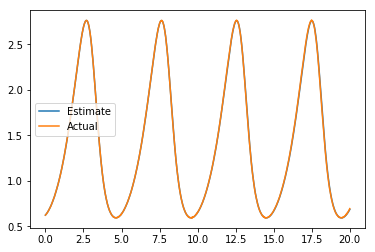

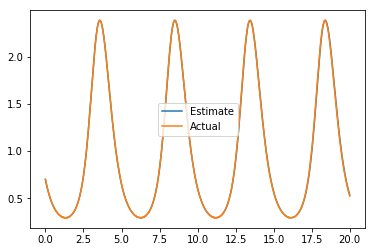

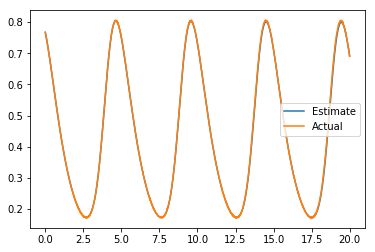

In [6]:
import numpy as np
from sparse_identification import sindy
from scipy.linalg import block_diag
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Lotka_Volterra import Lotka_Volterra, Identified_Model

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
t = np.linspace(0, 5, 2000)
t_extended = np.linspace(0, 20, 2000)
total = 0
x, dx = [], []
while total < 5:
    x0 = np.random.uniform(-2, 2, 3) # Initial condition.
    x_temp, dx_temp = Lotka_Volterra(x0, alpha, beta, t, noise=0.001)
    if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)):
        continue
    total += 1
    x.append(x_temp)
    dx.append(dx_temp)

x, dx = np.concatenate(x), np.concatenate(dx)
library = PolynomialFeatures(degree=2, include_bias=True)
Theta = library.fit_transform(x)
n_lib = library.n_output_features_
A = block_diag(Theta, Theta, Theta)
b = dx.flatten(order='F')

shols = sindy(l1=0.01, solver='lstsq')
shols.fit(A, b)
x_ident = odeint(Identified_Model, x0, t_extended, args=(library, shols))
x_extended, _ = Lotka_Volterra(x0, alpha, beta, t_extended, noise=0.001)
for i in range(x_ident.shape[1]):
    plt.plot(t_extended, x_ident[:, i], label='Estimate')
    plt.plot(t_extended, x_extended[:, i], label='Actual')
    plt.legend()
    plt.show()

In [22]:
shols.coef_

array([  2.46085874,  -0.07313917,  -5.6199511 ,  -1.72823288,
         0.26889164,   0.        ,   0.20115408,   1.09673366,
         2.7075639 ,   0.99362298,   9.28327624,   0.17889204,
       -11.94268805,   2.87693152,   0.18835661,   2.92790161,
       -10.64651369,   2.16568192,   4.21142359,  -0.60010986,
        -0.80533603,   0.42588474,   3.40650807,  -0.72014922,
        -0.13499181,  -0.60082558,  -0.20865381,  -0.67282662,
        -0.62445181,  -0.2682938 ])

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/cvxopt/coneprog.py:4329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


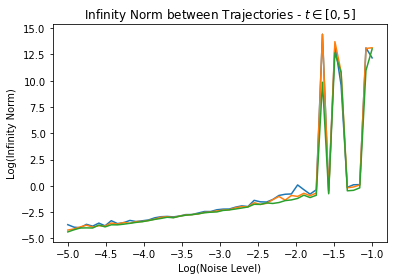

In [9]:
import numpy as np
np.random.seed(1337)
from sparse_identification import sindy
from scipy.linalg import block_diag
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Lotka_Volterra import Lotka_Volterra, Identified_Model

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
t = np.linspace(0, 5, 2000)
noise_level = np.logspace(-5, -1, 50)
diff = []
for noise in noise_level:
    noise_diff = []
    for _ in range(10):
        total = 0
        x, dx = [], []
        while total < 5:
            x0 = np.random.uniform(-2, 2, 3) # Initial condition.
            x_temp, dx_temp = Lotka_Volterra(x0, alpha, beta, t, noise=noise)
            if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)):
                continue
            total += 1
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta)
        b = dx.flatten(order='F')

        shols = sindy(l1=0.01, solver='lstsq')
        shols.fit(A, b)
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
    diff.append(np.mean(noise_diff, axis=0))

plt.plot(np.log10(noise_level), np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [0, 5]$')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.savefig('31_a.png')
plt.show()

/home/alexander/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/alexander/anaconda3/lib/python3.6/site-packages/cvxopt/coneprog.py:4329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


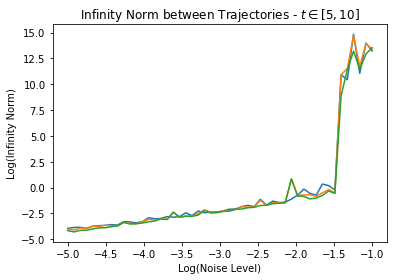

In [10]:
import numpy as np
np.random.seed(1337)
from sparse_identification import sindy
from scipy.linalg import block_diag
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Lotka_Volterra import Lotka_Volterra, Identified_Model

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
t = np.linspace(0, 5, 2000)
t_extended = np.linspace(5, 10, 2000)
noise_level = np.logspace(-5, -1, 50)
diff = []
for noise in noise_level:
    noise_diff = []
    for _ in range(10):
        total = 0
        x, dx = [], []
        while total < 5:
            x0 = np.random.uniform(-2, 2, 3) # Initial condition.
            x_temp, dx_temp = Lotka_Volterra(x0, alpha, beta, t, noise=noise)
            if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)):
                continue
            total += 1
            x.append(x_temp)
            dx.append(dx_temp)
            
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta)
        b = dx.flatten(order='F')

        shols = sindy(l1=0.01, solver='lstsq')
        shols.fit(A, b)
        x_ident = odeint(Identified_Model, x0, t_extended, args=(library, shols))
        x_extended, _ = Lotka_Volterra(x0, alpha, beta, t_extended, noise=noise) 
        inf_norm = np.max(np.abs(x_ident.T - x_extended.T), axis=1)
        noise_diff.append(inf_norm)
    diff.append(np.mean(noise_diff, axis=0))


plt.plot(np.log10(noise_level), np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [5, 10]$')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.savefig('31_b.png')
plt.show()

## SINDy on Missing Variables System

In [ ]:
import numpy as np
from sparse_identification import sindy
from scipy.linalg import block_diag
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Lotka_Volterra import Lotka_Volterra, Identified_Model

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
t = np.linspace(0, 5, 2000)
t_extended = np.linspace(0, 20, 2000)
total = 0
x, dx = [], []
while total < 5:
    x0 = np.random.uniform(-2, 2, 3) # Initial condition.
    x_temp, dx_temp = Lotka_Volterra(x0, alpha, beta, t, noise=0.001)
    if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)):
        continue
    total += 1
    x.append(x_temp)
    dx.append(dx_temp)

x, dx = np.concatenate(x), np.concatenate(dx)
library = PolynomialFeatures(degree=2, include_bias=True)
Theta = library.fit_transform(x)
n_lib = library.n_output_features_
A = block_diag(Theta, Theta, Theta)
b = dx.flatten(order='F')

shols = sindy(l1=0.01, solver='lstsq')
shols.fit(A, b)
x_ident = odeint(Identified_Model, x0, t_extended, args=(library, shols))
x_extended, _ = Lotka_Volterra(x0, alpha, beta, t_extended, noise=0.001)
for i in range(x_ident.shape[1]):
    plt.plot(t_extended, x_ident[:, i], label='Estimate')
    plt.plot(t_extended, x_extended[:, i], label='Actual')
    plt.legend()
    plt.show()